TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.

In [1]:
from src.random_text import get_text
import matplotlib.pyplot as plt
from textblob import TextBlob
import networkx as nx
import numpy as np
import random

From Text to Word-adjacency networks

In [2]:
def get_network(text, disconnected_chars = ['.', ','], weighted=False):
    network = nx.DiGraph()
    words = text.split(" ")
    network.add_node(words[0])
    for (n, word) in enumerate(words[1:]):
        n+=1
        network.add_node(word)
        edge = (words[n-1], words[n])
        if edge in network.edges() and weighted:
            network.add_edge(edge[0], edge[1], weight=network.get_edge_data(*edge)['weight']+1)
        elif weighted: network.add_edge(*edge, weight=1)
        else: network.add_edge(*edge)
    
    network.remove_nodes_from(disconnected_chars)
    return network

Obtain text to analyse

In [3]:
text = get_text(size=10)

Convert from Text-To-Network

In [4]:
network = get_network(text, weighted=False)
print(network.edges())

[('salaried', 'protomagnate'), ('protomagnate', 'seismologic'), ('seismologic', 'cerecloth'), ('cerecloth', 'garget'), ('garget', 'pontify'), ('pontify', 'multipinnate'), ('multipinnate', 'propidene'), ('propidene', 'controversially'), ('controversially', 'tempse')]


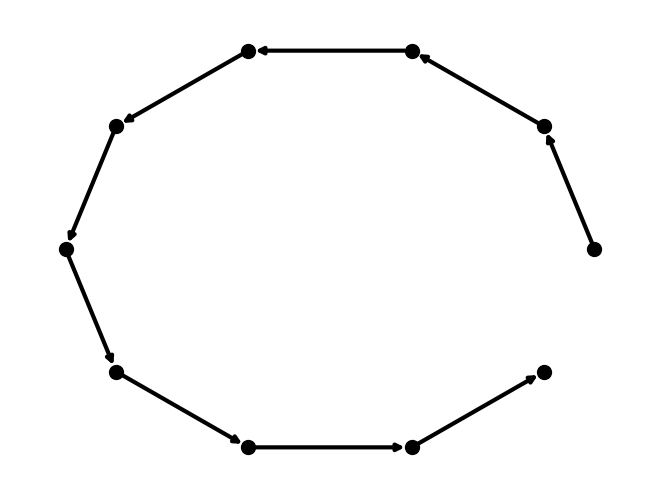

In [5]:
G = network
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw_circular(G, **options)
nw = plt.show()

Network Properties:

(1) Degree Distribuition: 


É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.


Probabilidade de haver um node com degree n > 2, num set de K palavras:
$$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}*(\frac{1}{k})^{n}$$


(2) Path Length:

(3) Clustering Coefficient:

(4) Connected Components:


## Estudo de um livro para estudo do random.

In [6]:
# Fellowship Of The Ring for random network definition purposes:

with open('The Fellowship Of The Ring.txt', 'r') as file:
    # Read the content of the file
    text = TextBlob(file.read())

# number of words
n_words = len(text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')

Fellowship Of The Ring has: 179550 words.
Fellowship Of The Ring has: 10132 distinct words.


In [7]:
# getting n_distinct_"words"
number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
# getting a combination of n_words with n_distinct_words as the base set
random_text = ' '.join(random.choices(number_set, k=n_words))
# generating the network as a list of tuples
network = get_network(random_text, weighted=False)


In [8]:
# average degree
avg_degree = np.mean([d for _, d in network.degree()])

Text(0, 0.5, 'Frequency (%)')

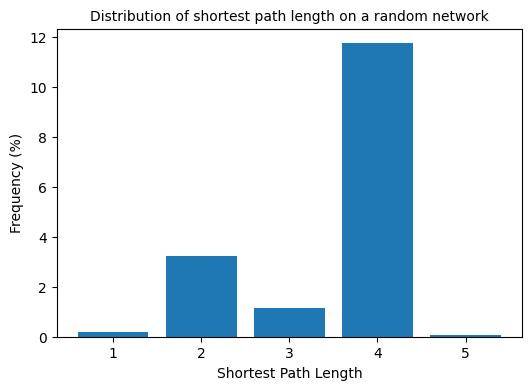

In [9]:
# Code from: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html (with a bit of tuning)

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
# Compute the average shortest path length for each node
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
# The average over all nodes
avg_path_lengths = np.mean(average_path_lengths)
# network diameter
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})

These are the top 10 nodes with highest degree centrality:
1543 -> 0.006712071858651664
310 -> 0.006712071858651664
6202 -> 0.006514657980456026
6425 -> 0.006514657980456026
3903 -> 0.006514657980456026
5771 -> 0.006514657980456026
8684 -> 0.006415951041358207
2 -> 0.006317244102260389
5141 -> 0.006317244102260389
4722 -> 0.006317244102260389


Text(0, 0.5, 'Counts')

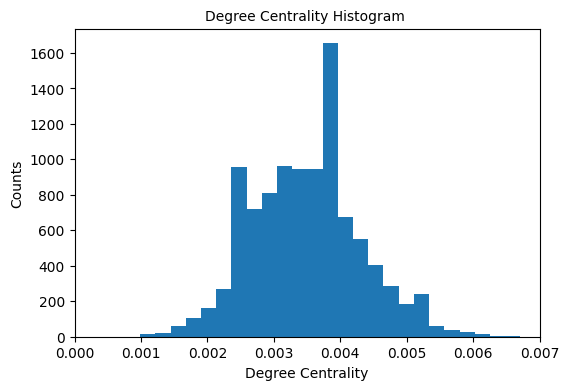

In [10]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

These are the top 10 nodes with highest betweenness centrality:
1543 -> 0.000822247934336466
310 -> 0.0008050781292738006
5771 -> 0.0007960111706124007
6202 -> 0.0007783252986770764
3903 -> 0.0007763358111155046
6425 -> 0.0007752681804119274
8684 -> 0.0007643198861044583
2 -> 0.0007545254205102933
5141 -> 0.0007473027435360301
7158 -> 0.000740483152604607


Text(0, 0.5, 'Counts')

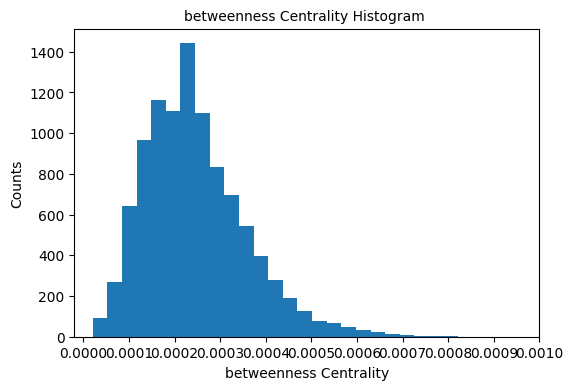

In [11]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(network)
# top 10 nodes by betweenness centrality
centrality = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

In [12]:
import matplotlib.pyplot as plt

def random_analysis(n):
    avg_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    for i in range(n):
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)

        avg_degree = np.mean([d for _, d in network.degree()])

        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))

        avg_list.append(avg_degree)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)
    ax_avg.set_ylabel('Value')
    ax_avg.set_title('Boxplot - avg_degree')

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)
    ax_degree.set_ylabel('Value')
    ax_degree.set_title('Boxplot - avg_degree_centrality')

    # Display the plots
    plt.show()


In [15]:
import matplotlib.pyplot as plt

def random_analysis(n):
    avg_list = []
    avg_path_lengths_list = []
    diameter_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    # Create a new figure for avg_path_lengths_list
    fig_path_length, ax_path_length = plt.subplots()

    # Create a new figure for diameter_list
    fig_diameter, ax_diameter = plt.subplots()

    for i in range(n):
        # generate a random network for the current step
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)
        # calculate the average degree
        avg_degree = np.mean([d for _, d in network.degree()])
        # calculate the average shortest path
        shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
        average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
        avg_path_lengths = np.mean(average_path_lengths)
        # calculate the diameter
        diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
        # calculate average degree centrality
        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))
        # add the values to their lists
        avg_list.append(avg_degree)
        avg_path_lengths_list.append(avg_path_lengths)
        diameter_list.append(diameter)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Set y-axis label
    ax_avg.set_ylabel('Value')
    ax_degree.set_ylabel('Value')
    ax_path_length.set_ylabel('Value')
    ax_diameter.set_ylabel('Value')

    # Set plot title
    ax_avg.set_title('avg_degree')
    ax_degree.set_title('avg_degree_centrality')
    ax_path_length.set_title('avg_path_length')
    ax_diameter.set_title('avg_diameter')

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)

    # Plot avg_path_lengths_list in fig_path_length
    ax_path_length.boxplot(avg_path_lengths_list)

    # Plot diameter_list in fig_diameter
    ax_diameter.boxplot(diameter_list)

    # Display the plots
    plt.show()


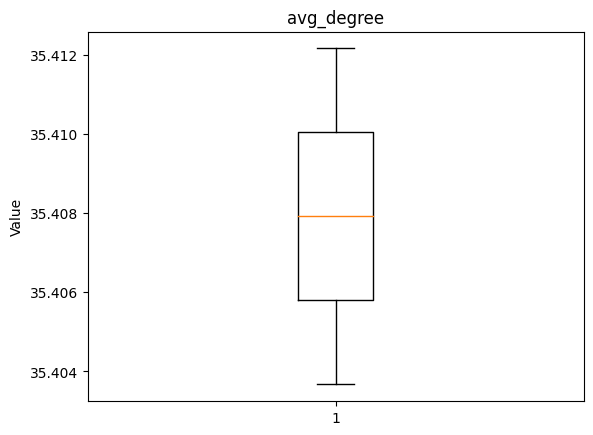

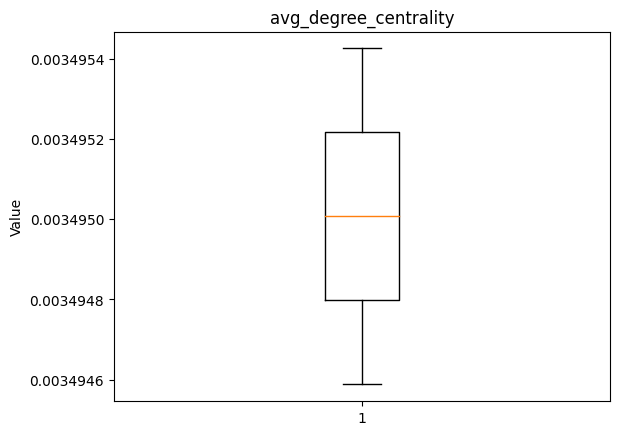

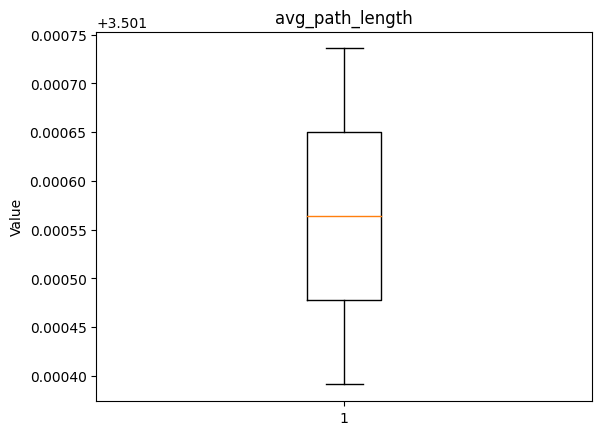

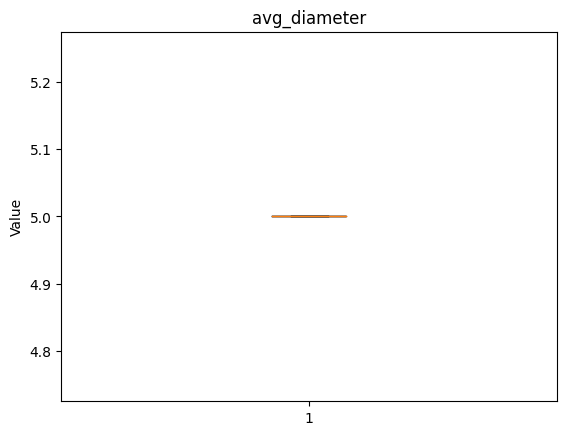

In [16]:
random_analysis(2)